# Consumer Reviews Summarization - Project Part 2


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)


## 1. Introduction
My project goal is to develop a baseline model using a Naive Bayes classifier, designed to summarize customer reviews. I chose to implement the Naive Bayes model because of its simplicity, speed, and resource efficiency. This is intended to help potential buyers quickly navigate through reviews when assessing a product. The system will focus on condensing the essential content of each review and its associated rating into a concise, single-sentence comment. These comments will be categorized as positive, neutral, or negative, aligning with the review's original rating. This approach will simplify the review evaluation process, making it more efficient.<br>
<br>

**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



## Prep

In [1]:
# Import all of the Python Modules/Packages 
#!pip install -U imbalanced-learn
#!pip install keras
#!pip install tensorflow
#!pip install wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import random

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.probability import FreqDist
from heapq import nlargest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from sklearn.metrics import log_loss
from nltk.probability import FreqDist

data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


In [2]:
# Count the number of nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Calculate the number of nulls in rating
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

# Get the shape after dropping null values
df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")


Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


In [3]:
# Review length of reviews
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 20 words 
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 20].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']

print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")

Longest review length: 668 words
Shortest review length: 20 words
Shape of the DataFrame after dropping rows below 20 words: (32857, 10)


In [4]:
# Clean reviews
stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stop words
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    # Join string
    review = ' '.join(words)
    return review

print(f"Done")

Done


In [6]:
# Converts it to a numerical format using TF-IDF vectorization and then splits the dataset into training and test sets.

df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Processed_Review'], df_cleaned['Cons_rating'], test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

# Fit to the training data 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X = df_cleaned['Processed_Review']
y = df_cleaned['Cons_rating']

# Now you can proceed with your existing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Calculate the total number 
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]


train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")


Total dataset size: 32857
Train size: 26285 (80.00%)
Test size: 6572 (20.00%)


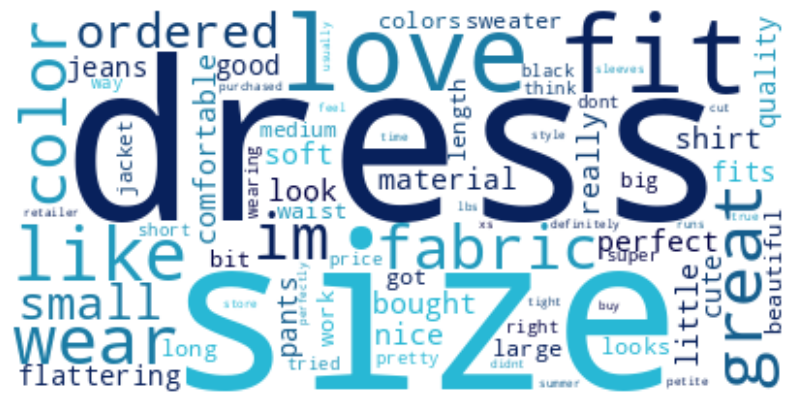

In [7]:
# Visualize the most significant words after TF-IDF 
# Define color 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs): 
    colors = ['#020344', '#08215C', '#0F3F74', '#155E8D', '#1B7CA5', '#229ABD', '#28B8D5'] 
    return random.choice(colors) 

sums = np.array(X_train_tfidf.sum(axis=0)).flatten()

words = tfidf_vectorizer.get_feature_names_out()
word_scores = {words[i]: sums[i] for i in range(len(words))}

wordcloud = WordCloud(background_color='white', color_func=color_func).generate_from_frequencies(word_scores)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


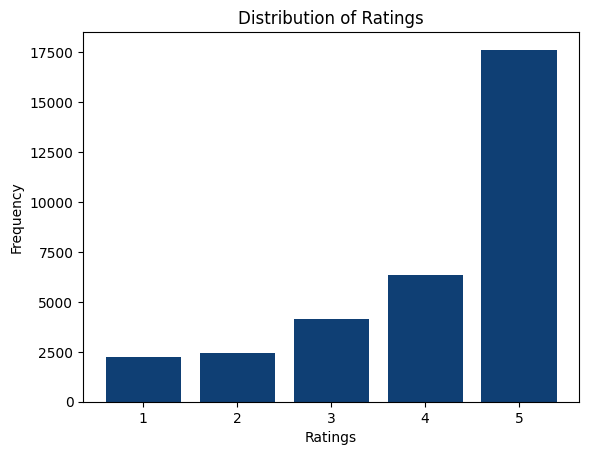

In [8]:
# Print ratings
unique_labels, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots()

ax.bar(unique_labels, counts, color='#0F3F74')

# Set x-ticks to the unique labels
ax.set_xticks(unique_labels)
# Set x-tick labels to the corresponding original label names
# This assumes your original labels are a list that matches the encoded labels
original_labels = ['1', '2', '3', '4', '5'][:len(unique_labels)]

ax.set_xticklabels(original_labels)

ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Ratings')

plt.show()


Accuracy: 0.5366707242848447


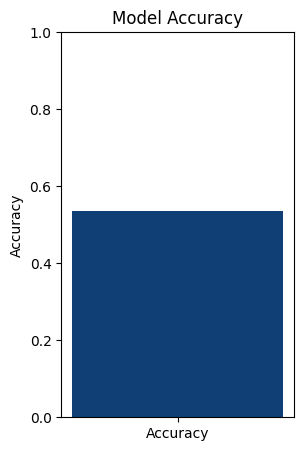

In [9]:
# Print accuracy

# Model Training
model = MultinomialNB()

#model.fit(X_train, y_train)
model.fit(X_train_tfidf, y_train)

# Predictions
#y_pred = model.predict(X_test)
y_pred = model.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the accuracy
plt.figure(figsize=(3, 5))  
plt.bar('Accuracy', accuracy, color='#0F3F74')
plt.ylim(0, 1)  
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


Train log loss: 1.174274406693175
Test log loss: 1.1777148641743451


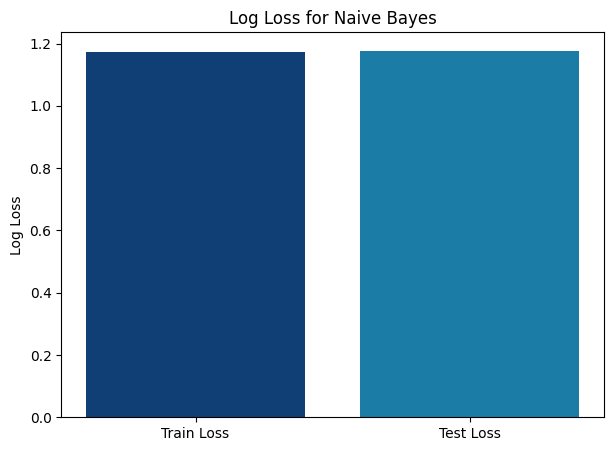

In [10]:
#Log loss

# Predict probabilities 
#train_pred_prob = model.predict_proba(X_train)
#test_pred_prob = model.predict_proba(X_test)

# Predict probabilities
train_pred_prob = model.predict_proba(X_train_tfidf)
test_pred_prob = model.predict_proba(X_test_tfidf)


# Calculate the log loss 
train_loss = log_loss(y_train, train_pred_prob)
test_loss = log_loss(y_test, test_pred_prob)

print('Train log loss:', train_loss)
print('Test log loss:', test_loss)

# Plotting the log loss 
plt.figure(figsize=(7, 5))
plt.bar(['Train Loss', 'Test Loss'], [train_loss, test_loss], color=['#0F3F74', '#1B7CA5'])
plt.title('Log Loss for Naive Bayes')
plt.ylabel('Log Loss')
plt.show()


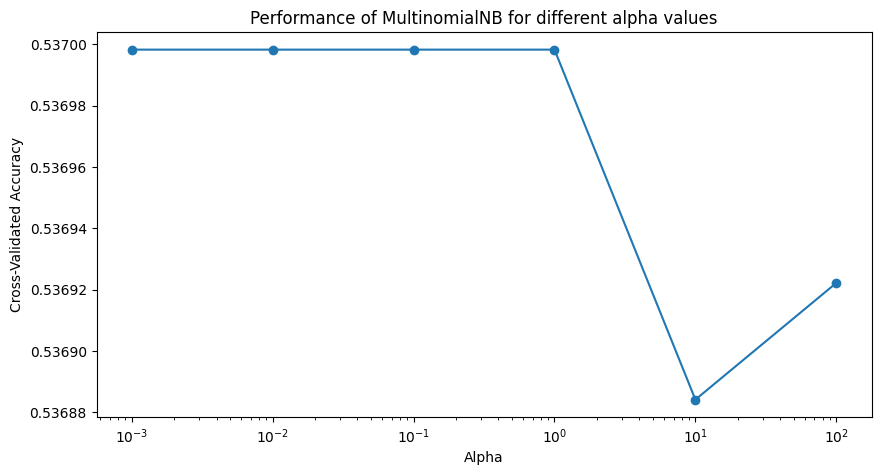

Best alpha: 0.001
Best cross-validated score: 0.5369982879969565


In [15]:
# Using grid search and visualize data - Model tuning plot

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alpha_values}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)

mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(alpha_values, mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Performance of MultinomialNB for different alpha values')
plt.show()

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validated score: {best_score}")


Test Accuracy with alpha=10: 0.5366707242848447


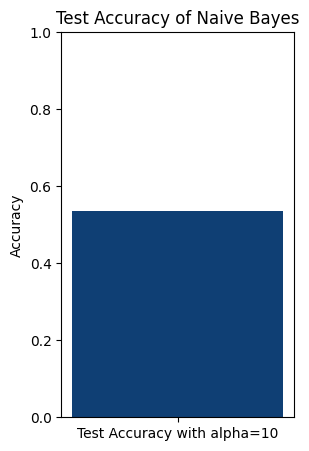

In [16]:
# Retrain NB model with the best alpha 

model = MultinomialNB(alpha=10)
#model.fit(X_train, y_train)

model.fit(X_train_tfidf, y_train)

# Evaluate on the test data
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy with alpha=10:", accuracy)

plt.figure(figsize=(3, 5))
plt.bar('Test Accuracy with alpha=10', accuracy, color='#0F3F74')
plt.ylim(0, 1)  
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Naive Bayes')
plt.show()

In [13]:
# Summarize text reviews by extracting key words

# Summarize_review function
def summarize_review(review, rating, num_sentences=2):

    stopWords = set(stopwords.words("english"))
    words = word_tokenize(review.lower()) 

    freqTable = FreqDist(words)
    sentences = sent_tokenize(review)
    sentenceValue = dict()

    for sentence in sentences:
        for word, freq in freqTable.items():
            if word in sentence.lower():
                if sentence in sentenceValue:
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq

    summary_sentences = nlargest(num_sentences, sentenceValue, key=sentenceValue.get)
    summary = ' '.join(summary_sentences)

    # Determine the sentiment based on the rating
    sentiment = ''
    if rating < 3:
        sentiment = 'Negative'
    elif rating == 3:
        sentiment = 'Neutral'
    else:
        sentiment = 'Positive'

    # Adjust sentence scores based on the determined sentiment
    if sentiment == 'Negative':
        negative_sentiment_words = ['bad', 'worst', 'terrible']  
        for sentence in sentences:
            if any(negative_word in sentence.lower() for negative_word in negative_sentiment_words):
                sentenceValue[sentence] *= 1.5 
    return summary

# Clean
df['Review'] = df['Review'].astype(str)
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))
mask = df['Word_Count'] >= 20
df = df[mask]

def determine_sentiment(rating):
    if rating < 3:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the summarization 
df['Summarized_Review'] = df.apply(lambda x: summarize_review(x['Review'], x['Cons_rating'], num_sentences=2), axis=1)

for index, row in df.head(15).iterrows():
    original_review = row['Review']
    summarized_review = row['Summarized_Review']
    
    sentiment = determine_sentiment(row['Cons_rating'])

    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())

    print("Original Review:", original_review)
    print("Original Review Word Count:", original_word_count)
    print("Original Review Sentiment:", sentiment)  
    print()
    print("Summarized Review:", summarized_review)
    print("Summarized Review Word Count:", summarized_word_count)
    print('-' * 100)


Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Original Review Word Count: 62
Original Review Sentiment: Positive

Summarized Review: i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. would definitely be a true midi on someone who is truly petite.
Summarized Review Word Count: 36
----------------------------------------------------------------------------------------------------
Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. o

## Conclusion
The project's goal was to create a baseline model using Naive Bayes to summarize textual reviews while taking into account the sentiment expressed by each review's rating. By cleaning the text data by removing stopwords, tokenizing, and leveraging frequency distributions of words I developed a summarization function that captures the essence of longer reviews and summerizes them.